The cryptoswap equation given in the Curve whitepaper is

$$ K D^{n-1} \sum_i x_i + \prod_i x_i = K D^n + \left(\frac{D}{n}\right)^n $$

$$ K = A K_0 \frac{\gamma^2}{(\gamma +1 - K_0)^2} $$


$$ K_0 = \frac{\prod x_i n^n}{D^n} $$


The $x_i$'s are the pool balances for each token.

Note $K$ is a function of the balances $x_i$ and $D$.

$D$ is the stableswap invariant.

$A$ is the amplification coefficient.

$\gamma > 0$



In [324]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt


In [325]:
MIN_GAMMA = 10**10
MAX_GAMMA = 2 * 10**16
A_MULTIPLIER = 10000

def newton_D(
    ANN,
    gamma,
    balances,
):
    """
    Finding the `D` invariant using Newton's method.
    """
    n_coins: int = len(balances)
        
    ANN = int(ANN * A_MULTIPLIER)
    gamma = int(gamma * 10**18)
    
    # Safety checks
    min_A = n_coins**n_coins * A_MULTIPLIER // 10
    max_A = n_coins**n_coins * A_MULTIPLIER * 100000
    assert min_A <= ANN <= max_A, "Unsafe value for A"
    assert MIN_GAMMA <= gamma <= MAX_GAMMA, "Unsafe value for gamma"

    # Initial value of invariant D is that for constant-product invariant
    x = [b * 10**18 for b in balances]
    if x[0] < x[1]:
        x = x[1], x[0]
        
    assert (
        x[0] > 10**9 - 1 and x[0] < 10**15 * 10**18 + 1
    )  # dev: unsafe values x[0]
    assert x[1] * 10**18 // x[0] > 10**14 - 1  # dev: unsafe values x[i] (input)

    D: int = n_coins * _geometric_mean(x, False)
    S: int = x[0] + x[1]

    for _ in range(255):
        D_prev: int = D

        K0: int = (10**18 * n_coins**2) * x[0] // D * x[1] // D

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = (
            10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // ANN
        )

        # 2*N*K0 / _g1k0
        mul2: int = (2 * 10**18) * n_coins * K0 // _g1k0

        neg_fprime: int = (
            (S + S * mul2 // 10**18) + mul1 * n_coins // K0 - mul2 * D // 10**18
        )

        # D -= f / fprime
        D_plus: int = D * (neg_fprime + S) // neg_fprime
        D_minus: int = D * D // neg_fprime
        if 10**18 > K0:
            D_minus += D * (mul1 // neg_fprime) // 10**18 * (10**18 - K0) // K0
        else:
            D_minus -= D * (mul1 // neg_fprime) // 10**18 * (K0 - 10**18) // K0

        if D_plus > D_minus:
            D = D_plus - D_minus
        else:
            D = (D_minus - D_plus) // 2

        diff = abs(D - D_prev)
        if diff * 10**14 < max(
            10**16, D
        ):  # Could reduce precision for gas efficiency here
            # Test that we are safe with the next newton_y
            for _x in x:
                frac: int = _x * 10**18 // D
                assert 10**16 <= frac <= 10**20, "Unsafe value for x[i]"
            return D // 10**18

    raise Exception("Did not converge")
        
        
        
def _geometric_mean(unsorted_x, sort: bool) -> int:
    """
    (x[0] * x[1] * ...) ** (1/N)
    """
    n_coins: int = len(unsorted_x)
    x = unsorted_x
    if sort and x[0] < x[1]:
        x = [unsorted_x[1], unsorted_x[0]]

    D: int = x[0]
    diff: int = 0
    for _ in range(255):
        D_prev: int = D
        D = (D + x[0] * x[1] // D) // n_coins
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise Exception("Did not converge")

## Imbalanced pool under change of gamma

Similar to ramping $A$ up or down, ramping $\gamma$ up will increase profit while ramping down will decrease profit.

gamma: 0.01 D: 2968 X_cp: 1484.0
gamma: 0.001 D: 2877 X_cp: 1438.5
gamma: 1e-08 D: 2828 X_cp: 1414.0


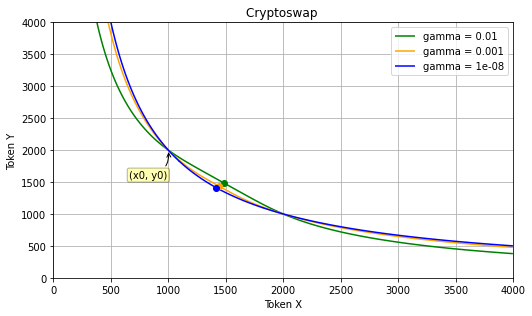

In [326]:
# D = 3000
x0, y0 = 1000, 2000
A = 250
n = 2
p = 1

fig, ax = plt.subplots()
x_end = 4000.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)

gammas = [1e-2, 1e-3, 1e-8]
colors = ['green', 'orange', 'blue']
legend_elements = []
for gamma, color in zip(gammas, colors):
    Ann = A * n**n
    D = newton_D(Ann, gamma, [p * x0, y0])

    K0 = p * x * y* n**n / D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K * D**(n - 1) * (p * x + y) + p * x * y - K * D**n - (D / n)**n
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])
    
    x_eq, y_eq = D / (2*p), D / 2
    xcp = sqrt(x_eq * y_eq)
    ax.plot(x_eq, y_eq, marker='o', color=color)

    print("gamma:", gamma, "D:", D, "X_cp:", xcp)

    
labels = [f'gamma = {gamma}' for gamma in gammas]
plt.legend(legend_elements, labels)

ax.annotate('(x0, y0)', xy=(x0, y0), xytext=(-20,-30), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='black'))

plt.show()

## Price scale repeg

Note: prices assume `y` token is the quote currency.

When the price scale is adjusted ("repegging"), this will lead to a loss for the LP.  This can be seen easily from the below graph.  The cryptoswap curve hugs the constant product curve from below, less tightly in the region of concentrated liquidity.  

Price scale: 1 D: 2077 X_cp: 1038.5
Price scale: 2 D: 2800 X_cp: 989.9494936611666


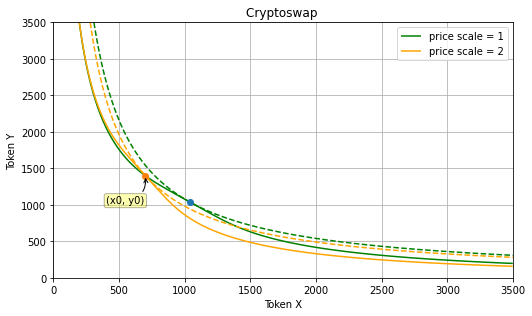

In [336]:
A = 250
n = 2
gamma = 0.01

fig, ax = plt.subplots()
x_end = 3500.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)

# D = 2100
x0, y0 = 700, 1400

prices = [1, 2]
colors = ['green', 'orange']
legend_elements = []
for p, color in zip(prices, colors):
    Ann = A * n**n
    D = newton_D(Ann, gamma, [p*x0, y0])
    xcp = sqrt((D/2) * D/(2*p))
    
    K0 = p*x*y*n**n/D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K*D**(n-1)*(p*x+y) + p*x*y - K*D**n - (D/n)**n
    
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])
    
    y_cp = (D**2/(4*p)) / xs
    ax.plot(xs, y_cp, ls='--', color=color, label="constant-product")
    
    x_eq, y_eq = D / (2*p), D / 2
    ax.plot(x_eq, y_eq, marker='o')

    xcp = sqrt(x_eq * y_eq)
    print("Price scale:", p, "D:", D, "X_cp:", xcp)
    
plt.legend(loc="upper right")

labels = [f'price scale = {p}' for p in prices]
plt.legend(legend_elements, labels)


ax.annotate('(x0, y0)', xy=(x0, y0), xytext=(-20,-30), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='black'))

plt.show()

### Pathological repegging

In some unrealistic conditions, repeg could cause the profit counter $X_{cp}$ to increase.  In particular, this can happen if the current price scale is suited for the existing token reserves but the pool wants to adjust the price scale toward a less balanced price scale.

price scale: 1.0 D: 2985.0 X_cp: 1492.5
price scale: 1.5 D: 3499.0 X_cp: 1428.4607683330566
price scale: 2.0 D: 3999.0 X_cp: 1413.8600089825018
price scale: 2.5 D: 4499.0 X_cp: 1422.7087193097539
price scale: 3.0 D: 4998.0 X_cp: 1442.7983227048749


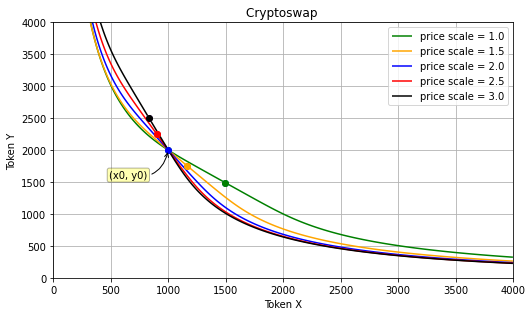

In [354]:
fig, ax = plt.subplots()
x_end = 4000.0
ax.set_xlim(0, x_end)
ax.set_ylim(0, x_end)

ax.set(xlabel='Token X', ylabel='Token Y',
       title='Cryptoswap ')
ax.grid()

delta = 2
xs = np.arange(0.1, x_end, delta)
ys = np.arange(0.1, x_end, delta)
x, y = np.meshgrid(xs, ys)

# D = 3000
x0, y0 = 1000, 2000
A = 750
n = 2


prices = [1.0, 1.5, 2.0, 2.5, 3.0]
gamma = 10**-2
colors = ['green', 'orange', 'blue', 'red', 'black']
legend_elements = []
for p, color in zip(prices, colors):
    Ann = A * n**n
    D = newton_D(Ann, gamma, [p * x0, y0])
    
    K0 = p * x * y* n**n / D**n
    K = A * K0 * gamma**2/(gamma + 1 - K0)**2
    cryptoswap_eqn = K * D**(n - 1) * (p * x + y) + p * x * y - K * D**n - (D / n)**n
    
    contour = ax.contour(x, y, cryptoswap_eqn, [0], colors=color)
    l, _ = contour.legend_elements()
    legend_elements.append(l[0])
    
    x_eq, y_eq = D / (2 * p), D / 2
    ax.plot(x_eq, y_eq, marker='o')
    
    xcp = sqrt(x_eq * y_eq)
    ax.plot(x_eq, y_eq, marker='o', color=color, label='equilibrium point')

    print("price scale:", p, "D:", D, "X_cp:", xcp)
    
ax.annotate('(x0, y0)', xy=(x0, y0), xytext=(-40,-30), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='black'))

labels = [f'price scale = {p}' for p in prices]
plt.legend(legend_elements, labels)
plt.show()